In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

Test empirical albedo model on 2003-2014 temperature data.

"""

# Import modules
import numpy as np
import xarray as xr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import netCDF4

In [4]:
# Define path
path = '/Users/jryan4/Dropbox (University of Oregon)/research/clouds/data/'

# Define summer albedo and temp. data
ds1 = xr.open_dataset(path + 'temp_albedo_summer_climatologies.nc')

# Define empirical model
model = pd.read_csv(path + 'empirical_albedo_model.csv')

# Define maximum snowline
snowline_file = netCDF4.Dataset(path + 'sci-adv-products/Monthly_Bare_Ice_2012.nc')
snowline = snowline_file.variables['bare_ice'][1, :, :].filled(np.nan)
max_snowline = (snowline > 0.1)

# Define cloud fraction
cloud_file = netCDF4.Dataset(path + 'modis_cloud_properties/cloud_fraction_2010.nc')
cloud_fraction = cloud_file.variables['cloud_fraction'][:]

# Define 2.5 K bins
bins = np.arange(-7.5, 20, 2.5)

# Define year
years = np.arange(0, 13, 1)

In [9]:
# Define reference grids for the 2015-2020 period
clrsky_albedo = np.mean(ds1['albedo'][:,:,12:], axis=2)

# Convert clear-sky albedo to all-sky albedo
correction = cloud_fraction * 5.0
reference_albedo = clrsky_albedo + correction

reference_temp = np.mean(ds1['t2m'][:,:,12:], axis=2)
reference_temp = reference_temp.where(reference_temp != -999)
reference_temp = reference_temp.where(ds1['mask'] != 0)

In [10]:
predicted = []
observed = []
for year in range(len(years)):
    
    print(year)
    # Normalize temperature to find bins
    summer_temp = ds1['t2m'][:,:,year].where(ds1['t2m'][:,:,year] != -999)
    normalized_temp = summer_temp - np.nanmean(reference_temp)

    # Find temperature difference
    temp_diff = summer_temp - reference_temp
    
    predicted_albedo_stack = np.zeros(temp_diff.shape)

    for i in range(len(bins) - 1):
        # Mask
        mask = (normalized_temp > bins[i]) & (normalized_temp < bins[i+1])

        # Stack
        predicted_albedo_stack = np.dstack((predicted_albedo_stack, reference_albedo + temp_diff.where(mask == 1) * model.iloc[i]['slope']))

    predicted_albedo = np.nansum(predicted_albedo_stack, axis=2)

    # Convert 0 to NaNs
    predicted_albedo[predicted_albedo == 0] = np.nan

    # Convert values < 0.3
    predicted_albedo[predicted_albedo < 30] = 30
    
    # Get ablation zone values
    predicted_albedo[~max_snowline] = np.nan
    
    # Correct observed albedo
    observed_albedo = ds1['albedo'][:,:,year] + correction

    # Remove NaNs
    p = predicted_albedo[np.isfinite(predicted_albedo)]
    o = observed_albedo.values[np.isfinite(predicted_albedo)]
    
    p = p[np.isfinite(o)]
    o = o[np.isfinite(o)]
    
    # Append to list    
    predicted.append(list(p / 100))
    observed.append(list(o / 100))

0
1
2
3
4
5
6
7
8
9
10
11
12


In [11]:
# Flatten lists
x = np.array([item for sublist in observed for item in sublist])
y = np.array([item for sublist in predicted for item in sublist])

# Stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
rmse = np.sqrt(np.mean((np.array(x) - np.array(y))**2))

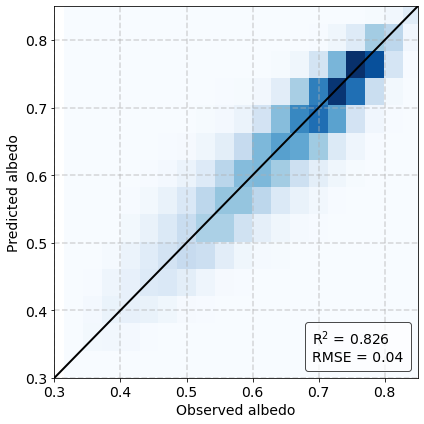

In [12]:
# Plot predicted vs. actual albedo
fig, (ax1) = plt.subplots(figsize=(6, 6))
ax1.hist2d(x, y, bins=(20,20), cmap='Blues')
ax1.plot([0.3, 0.85], [0.3, 0.85], color='k', lw=2, zorder=3)
ax1.set_ylabel('Predicted albedo', fontsize=14)
ax1.set_xlabel('Observed albedo', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.grid(ls='dashed', lw=1.5, alpha=0.5, zorder=1)
ax1.set_ylim(0.3, 0.85)
ax1.set_xlim(0.3, 0.85)

# Add stats
textstr = '\n'.join((
    r'R$^{2}$ = %.3f' % (r_value**2, ),
    r'RMSE = %.2f' % (rmse, )))
text_box = AnchoredText(textstr, frameon=True, loc=4, pad=0.5, prop=dict(size=14))
text_box.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.setp(text_box.patch, facecolor='white', alpha=0.7)
ax1.add_artist(text_box)

fig.tight_layout()
savepath = '/Users/jryan4/Dropbox (University of Oregon)/research/clouds/revised-manuscript/supp_figures/'
#plt.savefig(savepath + 'fig_sx_predicted_vs_actual_albedo.png', facecolor='w', transparent=False, dpi=200)